## Option 1 - Use MOOC Vectors
Could just read in the word embedding csv from the MOOC dataset instead of spending time / computation to make our own based off of a smaller corpus (The MOOC set is the one that claims to have made their vectors with over 12,000 coursera transcripts - will probably correspond to the type of "lecture" context we want)

In [2]:
#Make sure to have libraries installed if running yourself
import numpy as np
import pandas as pd
from numpy.linalg import norm
from numpy import dot
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [2]:
#MOOC dataset has options of vectors with 50, 100, 200, or 300 "features"
#May need to change based on speed / accuracy
#For reference, spaCy generates vectors with 300 features by default (will look at later)
embed_length = 300
df = pd.read_csv('..\\Datasets\\MOOC\\Word Embeddings\\MOOC_'+ str(embed_length) + 'd.csv')
df.columns = ['word'] + list(range(0,embed_length)) #Gives word column actual name
df = df.set_index(['word']) #Will make lookup faster
df = df[df.index.notnull()] #For some reason there are 2 words which get read as NaN, just ignoring for now
tokens = df.index.tolist() #The indicies of our dataframe are our tokens/words

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
word,,,,,,,,,,,,,,,,,,,,,
going,0.282224,0.216655,-0.836659,-0.063338,-0.208164,0.144238,1.155843,-0.331597,0.823568,0.402025,...,-0.030745,0.585437,0.474711,-0.689789,0.030715,1.123113,0.119392,-0.719813,-0.882543,0.351690
just,-0.112434,0.631439,-0.081427,0.288760,0.677108,-0.203446,0.820269,-0.031801,-0.704224,0.596509,...,0.021465,-0.480330,0.329963,-0.402903,0.168842,0.380508,-0.987448,-1.291400,-0.085132,-0.222390
like,0.631965,-0.453183,-0.256713,0.227004,-0.762930,-0.634983,0.233275,1.635337,-0.974890,0.609868,...,-0.105838,0.893409,0.058053,0.674091,0.925095,0.914846,0.048320,-0.386226,1.108918,0.008589
time,-1.363892,-0.254021,-0.689795,-0.419093,0.412053,-0.395511,0.212262,-0.298002,-1.061591,-0.993085,...,-0.227557,0.692057,0.266910,-0.145627,0.734603,-0.001361,-0.661998,-1.354438,0.563217,-0.117375
thing,-0.381017,0.863210,0.528545,0.508915,0.237749,0.277165,1.016616,-0.639115,-0.567647,0.924159,...,-0.145871,0.624864,0.114556,0.452468,0.706427,0.626805,-0.586004,-0.991389,0.265829,-0.329494


In [95]:
#Helper function to grab the vector from the dataframe
#Converts to numpy array so we can do things like add 2 vectors together
def vec(word):
    return df.loc[word].to_numpy()

#Cosine similarity is used to determine how 'similar' 2 words are in the context of the embeddings
def cosine_similarity(vector1, vector2):
    if norm(vector1) > 0 and norm(vector2) > 0:
        return dot(vector1, vector2) / (norm(vector1) * norm(vector2))
    else:
        return 0.0
    
#Function that returns the n "closest" words in the embedding context
#This is from some sort of spaCy/word2vec tutorial but I can't seem to find it again - will link it if I do
def n_closest(token_list, comp_vec, n=10):
    return sorted(token_list,
                 key=lambda v: cosine_similarity(comp_vec, vec(v)),
                 reverse=True)[:n]

In [5]:
n_closest(tokens, vec('king'))

['king',
 'pharaoh',
 'babylon',
 'prophet',
 'priest',
 'zedekiah',
 'temple',
 'gedaliah',
 'queen',
 'throne']

In [6]:
#Analogy example always used with word vectors. Queen shows up, but at the 6th closest
#Must have been a lot of history lectures talking about pharaohs, babylon, etc
n_closest(tokens, vec('king') - vec('male') + vec('female'))

['king',
 'pharaoh',
 'zedekiah',
 'gedaliah',
 'prophet',
 'queen',
 'babylon',
 'temple',
 'priest',
 'jeremiah']

In [7]:
n_closest(tokens, vec('fruit'))

['fruit',
 'vegetable',
 'maize',
 'sugar',
 'beef',
 'spinach',
 'veggie',
 'egg',
 'soybean',
 'mineral']

In [8]:
#Guess I should have seen this coming...
n_closest(tokens, vec('apple'))

['apple',
 'ipod',
 'iphone',
 'ipad',
 'walmart',
 'itunes',
 'amazon',
 'ereader',
 'ebay',
 'samsung']

### Visualization

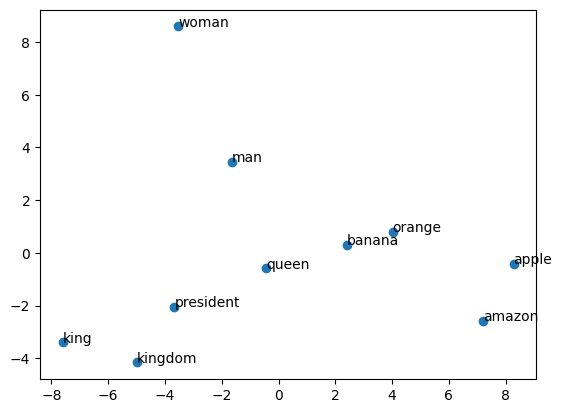

In [53]:
words = ['king','queen','man','woman','president','kingdom','apple','orange','banana','amazon']
X = [vec(w) for w in words]
pca = PCA(n_components=2)
res = pca.fit_transform(X)

plt.scatter(res[:,0],res[:,1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(res[i, 0], res[i, 1]))
plt.show()

## Option 2 - Use Gensim pretrained
Gensim (specifically the downloader) has some [pretrained models](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models) loaded as KeyedVector objects that could prove useful.  
The library also has some convenient functions already implemented

In [9]:
import gensim
import gensim.downloader

Uncomment one of the following models to load  
- Google News model is 1660 MB
- Wiki model is 950 MB
  
Note: these are just the vectors, not the model with its weights and everything. This means we can't use the predict_output_word() method unless we train a model ourselves. (However it is not recommended to use gensim models for this, and even the documentation calls this 'a crude way of using a trained model as a predictor')

In [10]:
#Pre-trained model generated from a Google News dataset (3 million word/phrase vectors) - also has 300-dimensional vectors
#model = gensim.downloader.load('word2vec-google-news-300')

#Pre-trained model generated from 2017 Wikipedia (1 million word vectors)
model = gensim.downloader.load('fasttext-wiki-news-subwords-300')

type(model)

gensim.models.keyedvectors.KeyedVectors

In [11]:
#Computes cosine similarity of two word vectors
model.similarity('legislator','politician')

0.73026234

In [19]:
#Finds the word that matches the others the least
model.doesnt_match('computer technology machine power bread electricity network data'.split())

'bread'

In [13]:
#10 most similar words
model.most_similar('facebook')

[('facebook.', 0.8114862442016602),
 ('facebooks', 0.7959319949150085),
 ('Facebook', 0.7885890007019043),
 ('twitter', 0.7708379030227661),
 ('facebook.com', 0.7622057199478149),
 ('facebooking', 0.737972617149353),
 ('non-Facebook', 0.7352786064147949),
 ('instagram', 0.7332959771156311),
 ('Facebook.', 0.7232986688613892),
 ('myspace', 0.7073581218719482)]

In [14]:
#More accurate in this example than our MOOC model
model.most_similar(model.get_vector('king') - model.get_vector('man') + model.get_vector('woman'))

[('king', 0.8185327053070068),
 ('queen', 0.7570335865020752),
 ('queen-mother', 0.6896809339523315),
 ('king-', 0.6787333488464355),
 ('queen-consort', 0.6555202603340149),
 ('monarch', 0.6455855965614319),
 ('kings', 0.6409086585044861),
 ('child-king', 0.6346831321716309),
 ('king-elect', 0.634436309337616),
 ('boy-king', 0.630662739276886)]

In [17]:
#This is what we lose out on without training, but that is okay
#It is not recommended to use this an the main benefit is the vectors themselves
model.predict_output_word('the quick brown fox jumped over the lazy dog'.split())

AttributeError: 'KeyedVectors' object has no attribute 'predict_output_word'

### Visualization

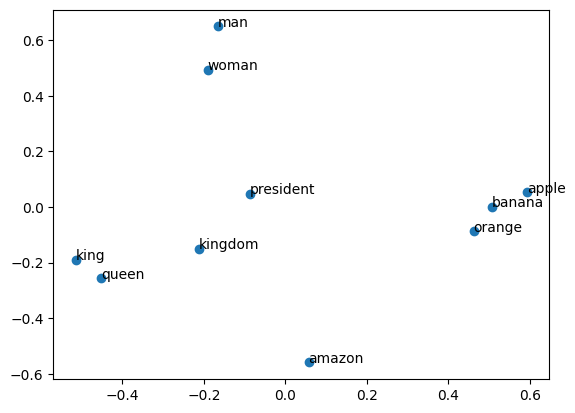

In [54]:
words = ['king','queen','man','woman','president','kingdom','apple','orange','banana','amazon']
X = [model.get_vector(w) for w in words]
pca = PCA(n_components=2)
res = pca.fit_transform(X)

plt.scatter(res[:,0],res[:,1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(res[i, 0], res[i, 1]))
plt.show()

## Option 3 - Use spaCy pretrained
spaCy also has its own pretrained word vector models

In [83]:
import spacy
#!python -m spacy download en_core_web_md

     --------------------------------------- 42.8/42.8 MB 17.7 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [125]:
#en_core_web_sm (35 MB) uses 96 dimensional vectors
#en_core_web_md (116 MB) and en_core_web_lg (812 MB) use 300 dimensional vectors
#The biggest spaCy model "en_vectors_web_lg" (612 MB) has 1.1 million unique 300 dimensional vectors
nlp = spacy.load('en_core_web_md')

In [87]:
nlp('tiger').vector

array([ 3.2863e-02,  1.8007e+00, -1.3854e+00, -3.5269e+00, -2.4236e-01,
        4.1086e-01,  2.6883e-01,  2.6619e-01,  2.2089e+00,  5.5610e-01,
        1.8365e+00,  1.8640e+00,  5.6364e-01,  2.8410e+00,  9.6371e-01,
       -4.9025e-01,  1.7455e+00, -9.0955e-01,  1.0285e+00, -9.1369e-01,
       -3.8807e+00,  4.3646e+00,  7.3652e-01, -1.9855e+00,  6.8695e-01,
       -1.1168e+00, -1.3848e+00, -4.3275e+00,  2.0860e+00, -1.2352e+00,
       -2.6987e+00, -3.1923e+00, -4.5478e-01, -3.2505e-01,  2.9277e+00,
       -2.8127e+00,  5.6524e-01,  2.5116e+00, -4.0011e-03, -2.2538e+00,
        9.6753e-01,  1.7537e+00,  1.9626e+00,  2.4178e+00,  9.5231e-01,
        7.9069e-01,  1.0563e+00, -2.3808e+00,  1.1095e+00,  2.5975e-01,
        1.8122e+00,  3.9573e+00,  2.6941e+00, -8.8950e-01, -2.1411e+00,
       -6.7690e-01,  1.4524e+00, -2.6874e+00,  1.0701e+00, -3.1616e+00,
       -7.6816e-01, -2.2863e+00,  9.8872e-02,  2.4057e+00, -1.9252e+00,
       -3.0326e+00, -2.1072e+00,  1.0391e+00,  1.4350e+00, -8.84

In [88]:
#Also has a cosine similarity function
nlp('cat').similarity(nlp('pet'))

0.7329664910082535

In [90]:
#Can also get vectors of entire sentences / documents (takes the average of the vectors of all tokens)
sen_vec = nlp('the quick brown fox').vector
len(sen_vec)

300

In [126]:
#Analogies with vector arithmetic
#spaCy doesn't have n-most similar words function - would have to implement ourselves
new_vec = nlp('king').vector - nlp('man').vector + nlp('woman').vector
cosine_similarity(new_vec, nlp('queen').vector)

0.6178015

Quick implementation of 'n most similar' for spaCy adapted from [this site](https://ashutoshtripathi.com/2020/09/04/word2vec-and-semantic-similarity-using-spacy-nlp-spacy-series-part-7/)

In [120]:
def spacy_similar(vec, n=10, as_lexeme=False):
    similarities = []
    for word in nlp.vocab:
        if word.has_vector and word.is_lower and word.is_alpha:
            similarities.append((word,cosine_similarity(vec,word.vector)))
    ret = sorted(similarities, key=lambda pair: pair[1], reverse=True)[:n]
    if not as_lexeme:
        return [w[0].text for w in ret]
    else:
        return ret

In [127]:
#Queen shows up high on the list here, which is good
#It seems every model so far still includes the original word as the closest when doing analogies
spacy_similar(new_vec)

['king',
 'queen',
 'and',
 'that',
 'havin',
 'where',
 'she',
 'they',
 'woman',
 'somethin']

### Visualizations

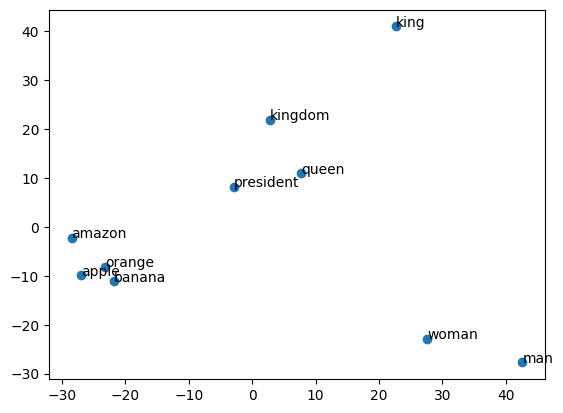

In [97]:
words = ['king','queen','man','woman','president','kingdom','apple','orange','banana','amazon']
X = [nlp(w).vector for w in words]
pca = PCA(n_components=2)
res = pca.fit_transform(X)

plt.scatter(res[:,0],res[:,1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(res[i, 0], res[i, 1]))
plt.show()

## Option 4 - Generate Embeddings with Gensim
It is said that generating your own word embeddings can sometimes yield better results since it better captures the domain.  

If we want to go this route, might as well use MOOC dataset instead since coursera lectures should be similar enough.     

Since we don't a have a giant dataset of 12,000 transcripts like the MOOC set did, this section will just use the TED talks transcripts as a proof of concept.

In [1]:
from gensim.parsing.preprocessing import preprocess_documents

In [5]:
#TODO ?

## Option 4.1 - Doc2Vec with Gensim
Generating vectors for entire documents

## Option 5 - Glove Embeddings
(Maybe separate notebook?)